In [1]:
import os
import glob

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter

import torchvision
from torchvision import transforms

import kornia as K

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *

from utils import plot_tensor, show_sample, learning_grid, create_loss_map

In [2]:
### --- Config --- ###
# dataset
target_rotation_deg = 100.

init_rotation_deg = 0.
# training
batch_size = 64
epochs = 1
lr=50
momentum=0.99
scheduler_iters = 10
use_scheduler=False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# paths:
run_name = f'init-{init_rotation_deg}_target-{target_rotation_deg}'

figures_dir = f'figures'
run_figures_dir = f'{figures_dir}/{run_name}'

gifs_dir = f'gifs'
run_gif_name = f'{gifs_dir}/{run_name}.gif'

os.makedirs(run_figures_dir, exist_ok=True)
os.makedirs(gifs_dir, exist_ok=True)

In [3]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    K.augmentation.RandomRotation(degrees=[target_rotation_deg,target_rotation_deg], p=1), # nn.Module
])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    target_augmentations
])

In [4]:
glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)

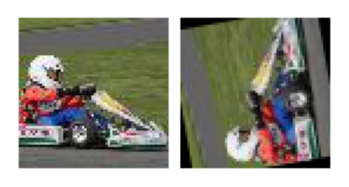

In [5]:
show_sample(dataset[0])

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [7]:
class AugmentationNetwork(nn.Module):
    def __init__(self, init_rot_degree):
        super().__init__()
        self.trans_param = Parameter(torch.Tensor([init_rot_degree]))

    def forward(self, x):
        clamped_param = torch.clamp(self.trans_param, min=-360.0, max=360.0)
        # clamped_param = torch.clamp(self.trans_param, min=-360.0, max=360.0)
        # clamped_param = torch.remainder(self.trans_param, 360.0)
        rand_rotation = K.augmentation.RandomRotation(
                        torch.cat([clamped_param, clamped_param]), p=1) # torch cat prevernts parameter from casting to float.
        out = rand_rotation(x)
        return out

In [8]:
model = AugmentationNetwork(init_rot_degree=init_rotation_deg)
model.to(device)

AugmentationNetwork()

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

trans_param tensor([0.], device='cuda:0')


In [10]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.93, last_epoch=-1, verbose=False)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.1, verbose=True)

Adjusting learning rate of group 0 to 5.0000e+01.


In [11]:
losses = []
lrs = []
p_progress = []
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        source_images, target_images = data
        source_images, target_images = source_images.to(device), target_images.to(device)
        
        optimizer.zero_grad()

        output_images = model(source_images)
        loss = criterion(output_images, target_images)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        running_loss += loss.item()
        print_every = 10
        if i % print_every == print_every - 1:
            print(f'[Epoch: {epoch+1} | Batch: {i+1} | MSE Loss: {running_loss/print_every:.3f} | {model.trans_param.item()}]')
            running_loss = 0.0

            with torch.no_grad():
                img_dict = {
                    "source": dataset[0][0],
                    "model's output": model(dataset[0][0]).squeeze(),
                    "target": dataset[0][1]
                }
                learning_grid(img_dict, save=f'{run_figures_dir}/epoch-{epoch+1:02}_batch-{i+1:05}.png')
        
        lrs.append(scheduler.get_last_lr())
        p_progress.append(model.trans_param.item())
        if use_scheduler:
            if i % scheduler_iters == scheduler_iters - 1 and i > 100:
                scheduler.step()


        if i == 1000:
            break

print('Finished Training.')

[Epoch: 1 | Batch: 10 | MSE Loss: 0.102 | 11.78182601928711]
[Epoch: 1 | Batch: 20 | MSE Loss: 0.094 | 25.726280212402344]
[Epoch: 1 | Batch: 30 | MSE Loss: 0.099 | 37.07295227050781]
[Epoch: 1 | Batch: 40 | MSE Loss: 0.099 | 47.54762268066406]
[Epoch: 1 | Batch: 50 | MSE Loss: 0.094 | 58.1845703125]
[Epoch: 1 | Batch: 60 | MSE Loss: 0.090 | 70.62273406982422]
[Epoch: 1 | Batch: 70 | MSE Loss: 0.068 | 87.36882019042969]
[Epoch: 1 | Batch: 80 | MSE Loss: 0.029 | 109.4307861328125]
[Epoch: 1 | Batch: 90 | MSE Loss: 0.052 | 119.53524017333984]
[Epoch: 1 | Batch: 100 | MSE Loss: 0.063 | 119.1818618774414]
[Epoch: 1 | Batch: 110 | MSE Loss: 0.053 | 109.51820373535156]
[Epoch: 1 | Batch: 120 | MSE Loss: 0.023 | 90.63258361816406]
[Epoch: 1 | Batch: 130 | MSE Loss: 0.055 | 84.22993469238281]
[Epoch: 1 | Batch: 140 | MSE Loss: 0.059 | 89.3760757446289]
[Epoch: 1 | Batch: 150 | MSE Loss: 0.026 | 107.73860168457031]
[Epoch: 1 | Batch: 160 | MSE Loss: 0.047 | 113.93891143798828]
[Epoch: 1 | Batch

In [12]:
os.makedirs(f'{run_figures_dir}/results', exist_ok=True)

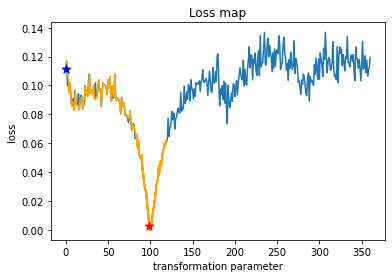

In [13]:
loss_map = create_loss_map(AugmentationNetwork, np.linspace(0,360,361),
                           dataloader, criterion,
                           save=run_name)
p_progress = [int(p % 360) for p in p_progress]
p_progress_losses = [loss_map[p] for p in p_progress]
final_param = int(model.trans_param.item() % 360)
statring_point = int(init_rotation_deg)
plt.plot(loss_map, zorder=2)
plt.scatter([statring_point], y=[loss_map[statring_point]], marker='*', c='b', s=80, zorder=4)
plt.scatter([final_param], y=[loss_map[final_param]], marker='*', c='r', s=80, zorder=4)
plt.plot(p_progress, p_progress_losses, c='orange', zorder=3)
plt.title('Loss map')
plt.xlabel('transformation parameter')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/loss_map.png')

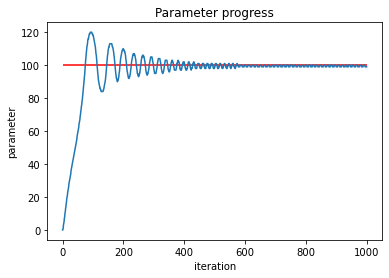

In [14]:
plt.plot(p_progress, zorder=7)
plt.hlines(y=[target_rotation_deg], xmin=[0], xmax=[len(p_progress)], color='r',zorder=5)
plt.xlabel('iteration')
plt.ylabel('parameter')
plt.title('Parameter progress')
plt.savefig(f'{run_figures_dir}/results/parameter_progress.png')

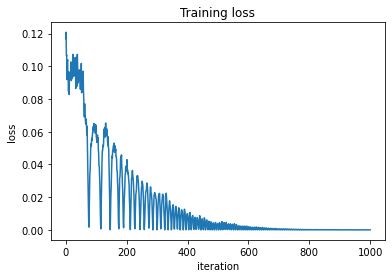

In [15]:
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/training_loss.png')

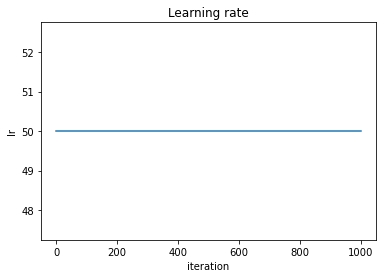

In [16]:
plt.plot(lrs)
plt.title('Learning rate')
plt.xlabel('iteration')
plt.ylabel('lr')
plt.savefig(f'{run_figures_dir}/results/learning_rate.png')

In [17]:
# filepaths
fp_in = f"{run_figures_dir}/epoch-*"
fp_out = run_gif_name

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=75, loop=0)